## Select articles: look for hateful comments

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-labelling")
db = client["hatespeech-labelling"]

In [2]:
Article.objects.count()

55110

In [3]:
db.article.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)], 'ns': 'hatespeech-labelling.article'},
 'comments.tweet_id_1': {'v': 2,
  'key': [('comments.tweet_id', 1)],
  'ns': 'hatespeech-labelling.article',
  'background': False},
 'created_at_1': {'v': 2,
  'key': [('created_at', 1)],
  'ns': 'hatespeech-labelling.article',
  'background': False},
 'tweet_idslug_1': {'v': 2,
  'key': [('tweet_idslug', 1)],
  'ns': 'hatespeech-labelling.article',
  'background': False},
 'user_1': {'v': 2,
  'key': [('user', 1)],
  'ns': 'hatespeech-labelling.article',
  'background': False},
 'body_text_title_text': {'v': 2,
  'key': [('_fts', 'text'), ('_ftsx', 1)],
  'ns': 'hatespeech-labelling.article',
  'background': False,
  'default_language': 'spanish',
  'weights': SON([('body', 1), ('title', 1)]),
  'language_override': 'language',
  'textIndexVersion': 3},
 'slug_1': {'v': 2,
  'unique': True,
  'key': [('slug', 1)],
  'ns': 'hatespeech-labelling.article',
  'background': False,
  'sparse': False}}

In [17]:
seeds = [
    "China", "Cuba", "Cubano", "bolivia",
    "Trump", "judío", "camionero", "agresor", 
    "policía" "ladrón" "reprimir" "represión"
    "juez", "justicia", "penal", "criminal", 
    "delito" "denunciar", "mamá", "género", 
    "aborto", "actriz", "feminista", "madre", 
    "femicidios", "mujer", "trans",
    "cristina", "macri", "morales", "canosa", "evo",
]

text_query = " ".join(seeds)

Article.objects.search_text(text_query).count()

35477

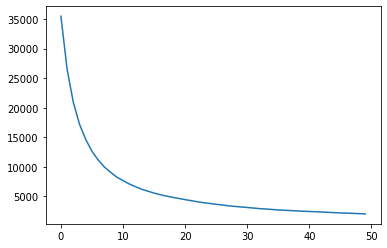

In [18]:
X = range(50)
Y = [Article.objects(**{f"comments__{i}__exists": True}).search_text(text_query).count() for i in X]

plt.plot(X, Y)

In [19]:
initial_query = {
    "comments__29__exists": True,
}
articles = Article.objects(**initial_query).search_text(text_query)
articles = list(articles)

print(len(articles))


3227


[737400. 737450. 737500. 737550. 737600. 737650. 737700.]


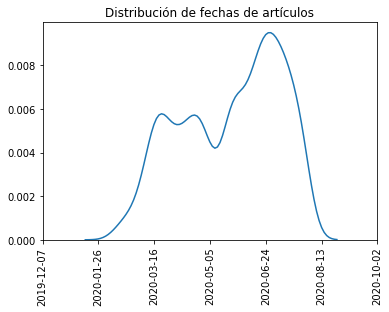

In [20]:
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.pyplot as plt

dates_dist = [a["created_at"] for a in articles]
ordinal_dates = [d.toordinal() for d in dates_dist]
sns.distplot(ordinal_dates, kde=True, hist=False)

locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos");

In [21]:
for article in articles:
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hateful_comments"] = len(hateful_comments) / len(article["comments"])
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


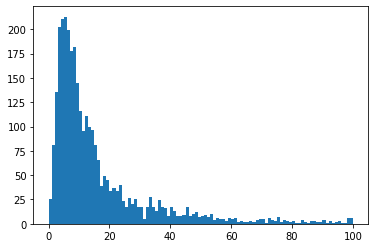

In [22]:
import matplotlib.pyplot as plt

plt.hist([c["num_hateful_comments"] for c in articles], range=[0, 100], bins=100);

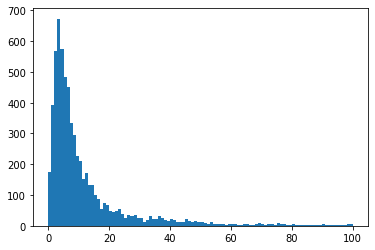

In [6]:
import matplotlib.pyplot as plt

plt.hist([c["num_hateful_comments"] for c in articles], range=[0, 100], bins=100);

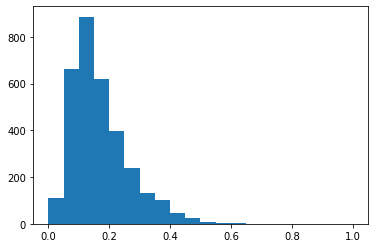

In [24]:
import matplotlib.pyplot as plt

plt.hist([c["avg_hate_value"] for c in articles], range=[0, 1], bins=20);

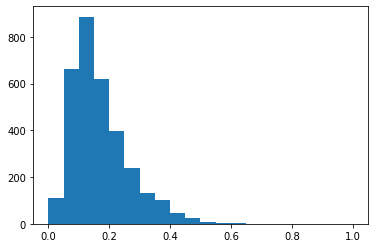

In [25]:
import matplotlib.pyplot as plt

plt.hist([c["avg_hate_value"] for c in articles], range=[0, 1], bins=20);

[737400. 737450. 737500. 737550. 737600. 737650. 737700.]


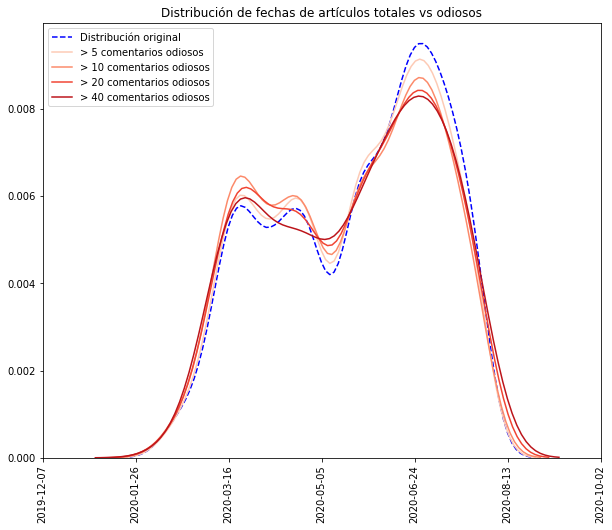

In [26]:
import random
random.seed(2020)


thresholded_hateful_articles_by_num = {
    k:[art for art in articles if art["num_hateful_comments"] >= k]
    
    for k in [5, 10, 20, 40]
}

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles_by_num))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles_by_num.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k} comentarios odiosos",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");

[737400. 737450. 737500. 737550. 737600. 737650. 737700.]


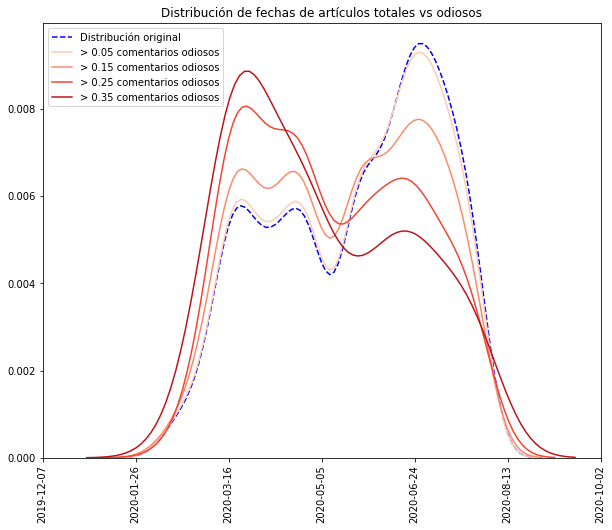

In [27]:
import random
import numpy as np

random.seed(2020)


thresholded_hateful_articles_by_comments_avg = {
    k:[art for art in articles if art["avg_hateful_comments"] > k]
    
    for k in np.arange(0.05, 0.45, 0.1)
}

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles_by_comments_avg))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles_by_comments_avg.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k:.2f} comentarios odiosos",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");
plt.savefig("pepe.png")

Parecieran tener una distribución similar, aunque podemos observar que en el segundo pico no pareciera haber tanta concentración de noticias odiosas

In [33]:
random.sample(articles, 30)

[1280343797650554883 - infobae
 Juana Viale se disculpó tras preguntar si Alberto Fernández terminará su mandato (43 comentarios),
 1274865504231084032 - infobae
 El Gobierno extenderá la cuarentena y en los próximos 60 días podrían perderse miles de empresas y empleos (54 comentarios),
 1272288029407940611 - infobae
 Jésica Cirio habló sobre la salud de Martín Insaurralde: “Está muy triste y asustado porque es un paciente de riesgo" (36 comentarios),
 1241039365721198593 - clarincom
 Coronavirus en Chile: sumó casi 100 casos nuevos en un día pero tildó de “decisión apresurada” la cuarentena en Argentina (166 comentarios),
 1245180397958369284 - infobae
 Marcelo Tinelli y Guillermina Valdés contaron intimidades de la pareja en un desafío viral (111 comentarios),
 1277662504563417091 - infobae
 La OMS aseguró que la pandemia de coronavirus no está “ni siquiera cerca” de terminar (32 comentarios),
 1239630940797886466 - clarincom
 Coronavirus, chicos sin clases y... mujeres con mayor car

In [11]:
from articles.models import Group
from mongoengine import DoesNotExist
    
random.seed(2020)


for key, hateful_articles in thresholded_hateful_articles_by_comments_avg.items():
    selected_articles = random.sample(hateful_articles, 30)
    group_name = f"Comments {key:.2f}"
    try:
        group = Group.objects.get(name=group_name)
    except DoesNotExist:
        group = Group(name=group_name)
    
    group.tweet_ids = [art["tweet_id"] for art in selected_articles]
    group.save()
    print(group)


Group object
Group object
Group object
Group object
